In [101]:
import os

# Define the base directory where your folders are located
base_dir = 'ray_osdi_11_23_2023'  # Replace with the path to your base directory

def find_all_csv_file_paths(path):
    csv_file_paths = []
    if os.path.isdir(path):
        for filename in os.listdir(path):
            if filename.endswith(".csv"):
                csv_file_paths.append(os.path.join(path, filename))
            else:
                csv_file_paths += find_all_csv_file_paths(os.path.join(path, filename))
    return csv_file_paths

def extract_variables_from_filename(filename):
    # Split the filename by underscores
    parts = filename.split('_')

    # Extract the variables based on your format
    replay_trace = parts[0]
    scheduler = parts[2]
    release_policy = parts[5]
    deadline_var = int(parts[9])
    dag_aware = parts[12].split('.')[0] == "1"  # Assuming the file extension is .csv

    if scheduler == "TetriSched":
        scheduler_time_discretization = int(parts[-1].split('.')[0])
        scheduler = f"TetriSched_time_dis_{scheduler_time_discretization}" + ("_DAG_aware" if dag_aware else "")
    else:
        scheduler_time_discretization = None
    
    # Create a dictionary to store the extracted variables
    variables = {
        'trace': replay_trace,
        'release_policy': release_policy,
        'max_deadline_variance': deadline_var,
        'scheduler': scheduler,
        'DAG_aware': dag_aware,
        'scheduler_time_discretization': scheduler_time_discretization
    }

    return variables

rows = []

# Loop through each folder and process the CSV file
for csv_file_path in find_all_csv_file_paths(base_dir):
    file_name = csv_file_path.split(os.sep)[-1]
    try:
        # Open the CSV file and read the last line
        with open(csv_file_path, 'r') as file:
            last_line = file.readlines()[-1]        
        end_time, _, finished_tasks, cancelled_tasks, missed_task_deadlines, finished_task_graphs, cancelled_task_graphs, missed_task_graph_deadlines = last_line.split(",")
        slo_attainment = int(finished_task_graphs) / (int(cancelled_task_graphs) + int(finished_task_graphs))
        print(f"{file_name},{last_line}")
        row = extract_variables_from_filename(file_name)
        row["slo_attainment"] = slo_attainment
        row["goodput"] = int(finished_tasks)
        rows.append(row)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except Exception as e:
        print(f"An error occurred while processing {csv_file_path}: {str(e)}")


alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv,1073,SIMULATOR_END,5,381,0,4,96,0

alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_100_dag_aware_0_scheduler_discretization_10.csv,1073,SIMULATOR_END,2,384,0,2,98,0

alibaba_scheduler_TetriSched_release_policy_poisson_max_deadline_var_100_dag_aware_1_scheduler_discretization_10.csv,2405,SIMULATOR_END,216,171,0,37,63,0

alibaba_scheduler_TetriSched_release_policy_poisson_max_deadline_var_200_dag_aware_1_scheduler_discretization_20.csv,2536,SIMULATOR_END,195,192,0,30,70,0

alibaba_scheduler_TetriSched_release_policy_gamma_max_deadline_var_100_dag_aware_0_scheduler_discretization_10.csv,247583,SIMULATOR_END,2,384,0,2,98,0

alibaba_scheduler_TetriSched_release_policy_gamma_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv,247583,SIMULATOR_END,2,384,0,2,98,0

alibaba_scheduler_EDF_release_policy_fixed_max_deadline_var_50_dag_aware_0.csv,2142,SI

In [122]:
from dataclasses import dataclass


fixed_policy = {}
poisson_policy = {}
gamma_policy = {}

@dataclass
class TaskRelease:
    task_graph: str
    task_name: str
    release_time: int
    deadline: int

for csv_file_path in find_all_csv_file_paths(base_dir):
    file_name = csv_file_path.split(os.sep)[-1]
    variables = extract_variables_from_filename(file_name)

    try:
        # Open the CSV file and read the last line
        with open(csv_file_path, 'r') as file:
            lines = file.readlines()

        task_release_time_map = {}
        for line in lines:
            if "TASK_RELEASE" not in line:
                continue
            # event_time should be the actual release time
            event_time, _, task_name, _, task_intended_release_time, task_release_time, task_deadline, task_id, task_graph = line.strip().split(",")
            # print(f"{task_name},{task_intended_release_time},{task_release_time},{task_deadline},{task_graph}")
            event_time = int(event_time)
            task_deadline = int(task_deadline)
            task_release_time_map[task_graph + "-" + task_name] = TaskRelease(task_graph, task_name, event_time, task_deadline)
            
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except Exception as e:
        print(f"An error occurred while processing {csv_file_path}: {str(e)}")

    release_policy = variables["release_policy"]
    max_deadline_variance = variables["max_deadline_variance"]

    if release_policy == "fixed":
        fixed_policy.setdefault(max_deadline_variance, {})
        fixed_policy[max_deadline_variance][file_name] = task_release_time_map
    elif release_policy == "poisson":
        poisson_policy.setdefault(max_deadline_variance, {})
        poisson_policy[max_deadline_variance][file_name] = task_release_time_map
    elif release_policy == "gamma":
        gamma_policy.setdefault(max_deadline_variance, {})
        gamma_policy[max_deadline_variance][file_name] = task_release_time_map

In [125]:
for max_deadline_variance in fixed_policy:
    first_file_name = list(fixed_policy[max_deadline_variance].keys())[0]
    for file_name, task_release_time_map in fixed_policy[max_deadline_variance].items():
        if file_name == first_file_name:
            continue
        print(f"Comparing {first_file_name} and {file_name}")
        for task_graph_and_name, release in task_release_time_map.items():
            if task_graph_and_name not in fixed_policy[max_deadline_variance][first_file_name]:
                print(f"Task {task_graph_and_name} not found in {first_file_name}")
                continue
            first_release = fixed_policy[max_deadline_variance][first_file_name][task_graph_and_name]
            if release.release_time != first_release.release_time:
                print(f"Task {task_graph_and_name} release time mismatch: {release.release_time} != {first_release.release_time}")
            if release.deadline != first_release.deadline:
                print(f"Task {task_graph_and_name} deadline mismatch: {release.deadline} != {first_release.deadline}")

Comparing alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv and alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_1_scheduler_discretization_10.csv
Task j_2212258@1-J3 not found in alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv
Task j_650891@1-R3 not found in alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv
Task j_2962188@1-R2 not found in alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv
Task j_2962188@1-R5 not found in alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv
Task j_2212258@1-R4 not found in alibaba_scheduler_TetriSched_release_policy_fixed_max_deadline_var_200_dag_aware_0_scheduler_discretization_20.csv
Task j_676668@1-R

In [102]:
import pandas as pd

# Create a DataFrame from the rows list
data = pd.DataFrame(rows).sort_values("release_policy").sort_values("max_deadline_variance", ascending=True)
data.to_csv('output.csv', index=False)
# Print the DataFrame to verify its contents
data.head(30)

,trace,release_policy,max_deadline_variance,scheduler,DAG_aware,scheduler_time_discretization,slo_attainment,goodput
7,alibaba,gamma,50,EDF,False,NaN,1.00,387
28,alibaba,poisson,50,TetriSched_time_dis_20_DAG_aware,True,20.0,0.18,129
32,alibaba,poisson,50,TetriSched_time_dis_10_DAG_aware,True,10.0,0.31,184
14,alibaba,poisson,50,TetriSched_time_dis_10,False,10.0,0.08,8
40,alibaba,poisson,50,TetriSched_time_dis_20,False,20.0,0.03,3
41,alibaba,poisson,50,TetriSched_time_dis_1_DAG_aware,True,1.0,0.88,353
54,alibaba,poisson,50,TetriSched_time_dis_1,False,1.0,0.37,38
18,alibaba,gamma,50,TetriSched_time_dis_10_DAG_aware,True,10.0,0.23,167
22,alibaba,gamma,50,TetriSched_time_dis_20,False,20.0,0.01,1
51,alibaba,gamma,50,TetriSched_time_dis_1_DAG_aware,True,1.0,1.00,387


/tmp/ipykernel_2755559/2507031605.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  cat = sns.catplot(


Text(0.5, 0.98, 'SLO Attainment Comparison')

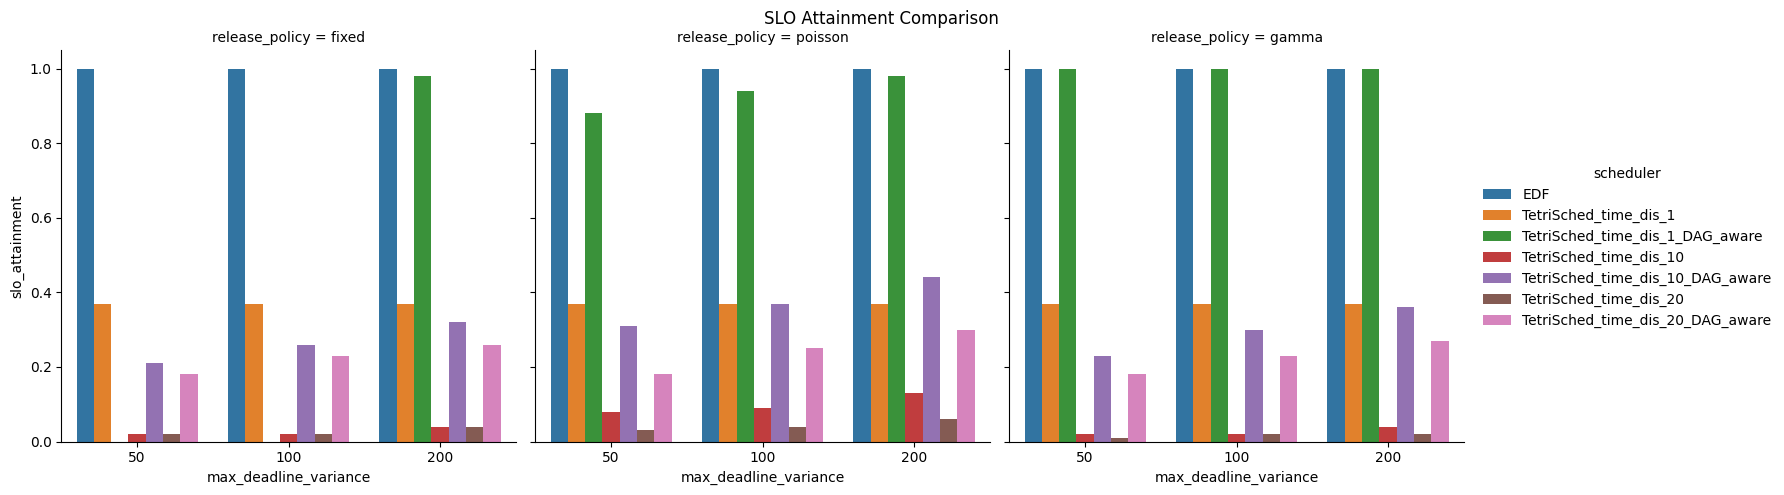

In [103]:
from matplotlib import pyplot as plt
import seaborn as sns

cat = sns.catplot(
            kind='bar', x="max_deadline_variance", y="slo_attainment", col='release_policy', col_order=["fixed", "poisson", "gamma"],
            hue="scheduler", hue_order=["EDF", "TetriSched_time_dis_1",  "TetriSched_time_dis_1_DAG_aware", "TetriSched_time_dis_10", "TetriSched_time_dis_10_DAG_aware", "TetriSched_time_dis_20", "TetriSched_time_dis_20_DAG_aware"],
            legend_out=True, data=data, ci=None)
cat.fig.subplots_adjust(top=0.9)
cat.fig.suptitle('SLO Attainment Comparison')

/tmp/ipykernel_2755559/907563801.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  cat = sns.catplot(


Text(0.5, 0.98, 'Goodput Attainment Comparison')

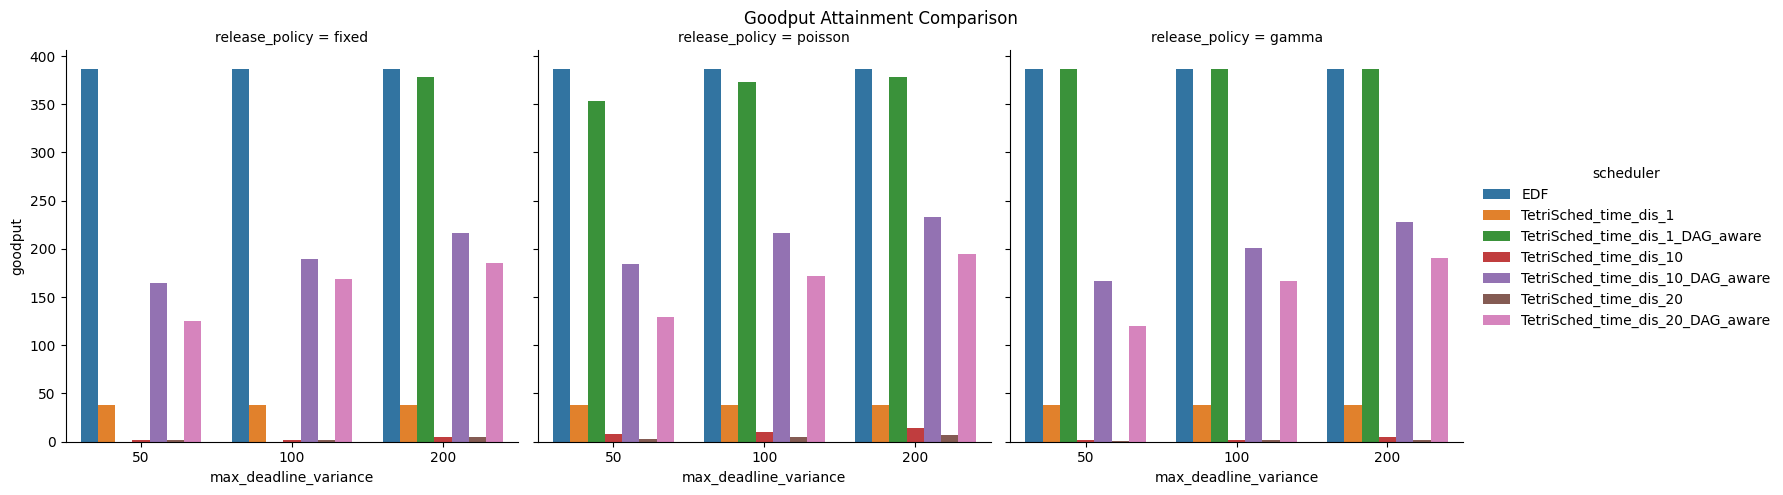

In [104]:
from matplotlib import pyplot as plt
import seaborn as sns

cat = sns.catplot(
            kind='bar', x="max_deadline_variance", y="goodput", col='release_policy', col_order=["fixed", "poisson", "gamma"],
            hue="scheduler", hue_order=["EDF", "TetriSched_time_dis_1",  "TetriSched_time_dis_1_DAG_aware", "TetriSched_time_dis_10", "TetriSched_time_dis_10_DAG_aware", "TetriSched_time_dis_20", "TetriSched_time_dis_20_DAG_aware"],
            legend_out=True, data=data, ci=None)
cat.fig.subplots_adjust(top=0.9)
cat.fig.suptitle('Goodput Attainment Comparison')